In [1]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
def center_in_45(image, target_size=45):
    h, w = image.shape
    
    squared = np.zeros((target_size, target_size), dtype=np.uint8)
    
    y_offset = (target_size - h) // 2
    x_offset = (target_size - w) // 2
    
    squared[y_offset:y_offset+h, x_offset:x_offset+w] = image
    return squared

def load_training_data(data_path, symbols, train_size=0.8):
    X_train, y_train = [], []
    
    for symbol in symbols:
        symbol_path = os.path.join(data_path, symbol)
  
        images = [f for f in os.listdir(symbol_path) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        images.sort()
         
        split_idx = int(len(images) * train_size)
        train_images = images[:split_idx]
        mapped_symbol = symbol
        
        for img_name in train_images:
            img_path = os.path.join(symbol_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.bitwise_not(img)
                img_resized = center_in_45(img)
                X_train.append(img_resized.flatten())
                y_train.append(mapped_symbol)
    
    return np.array(X_train), np.array(y_train)

def predict_symbol(model, image):
    image = cv2.bitwise_not(image)
    img_flat = image.flatten()
    prediction = model.predict([img_flat])
    return prediction[0]

class SequenceGenerator:
    def __init__(self, data_path):
        self.data_path = data_path
        self.symbols_data = {}
        self.available_symbols = []
        self.load_symbols()
    
    def load_symbols(self):
        """Загрузка всех символов из папок"""
        folders = [f for f in os.listdir(self.data_path) 
                  if os.path.isdir(os.path.join(self.data_path, f))]
        
        print("Загружаемые символы:", folders)
        
        for folder in folders:
            folder_path = os.path.join(self.data_path, folder)
            images = []
            
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_path = os.path.join(folder_path, filename)
                    images.append(file_path)
            
            if images:
                self.symbols_data[folder] = images
                self.available_symbols.append(folder)
                print(f"Символ '{folder}': {len(images)} изображений")
    
    def generate_sequence_image(self, length=8):
        """Генерация изображения с последовательностью символов"""
        if not self.available_symbols:
            return None
            
        sequence_images = []
        labels = []
        
        for i in range(length):
            symbol = random.choice(self.available_symbols)
            image_path = random.choice(self.symbols_data[symbol])
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            if image is not None:
                sequence_images.append(image)
                labels.append(symbol)
        
        spacing = 20
        total_width = sum(img.shape[1] for img in sequence_images) + spacing * (len(sequence_images) - 1)
        max_height = max(img.shape[0] for img in sequence_images)
        
        sequence_img = np.ones((max_height, total_width), dtype=np.uint8) * 255

        x_offset = 0
        for img in sequence_images:
            h, w = img.shape[:2]
            y_offset = (max_height - h) // 2
            sequence_img[y_offset:y_offset+h, x_offset:x_offset+w] = img
            x_offset += w + spacing
        
        return {
            'image': sequence_img,
            'labels': labels,
            'text': ''.join(labels),
            'individual_images': sequence_images
        }

class SequenceSegmenter:
    def extract_characters(self, sequence_image, original_labels):
        """Извлечение символов из последовательности"""
        print(f"Исходная последовательность: {' '.join(original_labels)}")
        
        non_space_labels = [label for label in original_labels if label != ' ']
        
        img_gray = sequence_image.copy()
        kernel = np.ones((3,3), np.uint8)
        img_gray = cv2.erode(img_gray, kernel, iterations=1)
        img_gray = cv2.bitwise_not(img_gray)
        
        ret, thresh = cv2.threshold(img_gray, 127, 255, 0)
        thresh = np.uint8(thresh)
        contours, h = cv2.findContours(thresh, cv2.RETR_EXTERNAL, 2)
        
        contours_sorted = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])
        crops = []

        img_with_boxes = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
        
        for i in range(len(contours_sorted)):
            cnt = contours_sorted[i] 
            x, y, w, h = cv2.boundingRect(cnt)
            while (w > 45):
                w -= 1
            if w * h > 50:
                cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 0, 255), 1)
                crops.append([x, y, w, h])

        plt.figure(figsize=(10, 3))
        plt.imshow(img_with_boxes)
        plt.title('Найденные контуры символов')
        plt.axis('off')
        plt.show()

        character_data = []
        for i in range(len(crops)):
            x, y, w, h = crops[i]
            
            img_crop = sequence_image[y:y+h, x:x+w]
            
            img_processed = cv2.bitwise_not(img_crop)
            img_resized = center_in_45(img_processed)
            
            true_label = non_space_labels[i] if i < len(non_space_labels) else "?"
            
            character_data.append((true_label, img_resized))
            print(f"Извлечен символ {i+1}: '{true_label}'")

        return character_data

In [3]:
DATA_PATH = './data'

print("=" * 60)
print("ЗАГРУЗКА ДАННЫХ И ОБУЧЕНИЕ МОДЕЛИ")
print("=" * 60)

symbols = []
if os.path.exists(DATA_PATH):
    symbols = [f for f in os.listdir(DATA_PATH) 
               if os.path.isdir(os.path.join(DATA_PATH, f))]

print("Доступные символы:", symbols)

if not symbols:
    print("Нет символов для обучения!")
    exit()

X_train, y_train = load_training_data(DATA_PATH, symbols, train_size=0.8)
print(f"Загружено {len(X_train)} изображений для обучения")

print("\nОБУЧЕНИЕ МОДЕЛЕЙ KNN:")
models = {}

knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)
models['knn1'] = knn1
print("KNN-1 обучен")

knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, y_train)
models['knn3'] = knn3
print("KNN-3 обучен")

knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, y_train)
models['knn5'] = knn5
print("KNN-5 обучен")

knn7 = KNeighborsClassifier(n_neighbors=7)
knn7.fit(X_train, y_train)
models['knn7'] = knn7
print("KNN-7 обучен")

print("Все модели успешно обучены!")

ЗАГРУЗКА ДАННЫХ И ОБУЧЕНИЕ МОДЕЛИ
Доступные символы: ['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'h', 't', 'times', 'w', 'X', 'y']
Загружено 180225 изображений для обучения

ОБУЧЕНИЕ МОДЕЛЕЙ KNN:
KNN-1 обучен
KNN-3 обучен
KNN-5 обучен
KNN-7 обучен
Все модели успешно обучены!



ТЕСТИРОВАНИЕ НА СГЕНЕРИРОВАННОЙ ПОСЛЕДОВАТЕЛЬНОСТИ
Загружаемые символы: ['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'h', 't', 'times', 'w', 'X', 'y']
Символ '(': 14294 изображений
Символ ')': 14355 изображений
Символ '+': 25112 изображений
Символ ',': 1906 изображений
Символ '-': 33997 изображений
Символ '0': 6914 изображений
Символ '1': 26520 изображений
Символ '2': 26141 изображений
Символ '3': 10909 изображений
Символ '4': 7396 изображений
Символ '5': 3545 изображений
Символ '6': 3118 изображений
Символ '7': 2909 изображений
Символ '8': 3068 изображений
Символ '9': 628 изображений
Символ 'h': 1464 изображений
Символ 't': 3274 изображений
Символ 'times': 3251 изображений
Символ 'w': 556 изображений
Символ 'X': 26594 изображений
Символ 'y': 9340 изображений


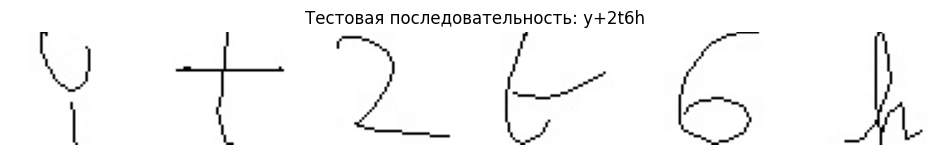

Исходная последовательность: y + 2 t 6 h


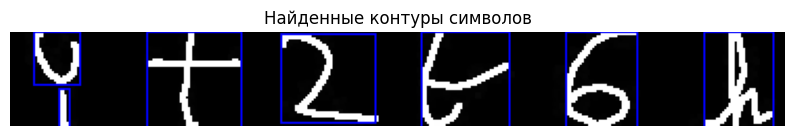

Извлечен символ 1: 'y'
Извлечен символ 2: '+'
Извлечен символ 3: '2'
Извлечен символ 4: 't'
Извлечен символ 5: '6'
Извлечен символ 6: 'h'
Извлечен символ 7: '?'

СРАВНЕНИЕ ТОЧНОСТИ МОДЕЛЕЙ

--- Модель knn1 ---
    - Символ 1: истина 'y', предсказано ')'
    - Символ 2: истина '+', предсказано '1'
    - Символ 3: истина '2', предсказано '+'
    - Символ 4: истина 't', предсказано '2'
    - Символ 5: истина '6', предсказано 't'
    - Символ 6: истина 'h', предсказано '6'
    - Символ 7: истина '?', предсказано 'h'
    Оригинал:  y+2t6h
    Предсказано: )1+2t6h
    Точность: 0.0% (0/6)

--- Модель knn3 ---
    - Символ 1: истина 'y', предсказано ')'
    - Символ 2: истина '+', предсказано '1'
    - Символ 3: истина '2', предсказано '+'
    - Символ 4: истина 't', предсказано '2'
    - Символ 5: истина '6', предсказано 't'
    - Символ 6: истина 'h', предсказано '6'
    - Символ 7: истина '?', предсказано 'h'
    Оригинал:  y+2t6h
    Предсказано: )1+2t6h
    Точность: 0.0% (0/6)

--- Моде

In [4]:
print("\n" + "=" * 60)
print("ТЕСТИРОВАНИЕ НА СГЕНЕРИРОВАННОЙ ПОСЛЕДОВАТЕЛЬНОСТИ")
print("=" * 60)

generator = SequenceGenerator(DATA_PATH)
sequence_data = generator.generate_sequence_image(length=6)

if sequence_data:
    plt.figure(figsize=(12, 3))
    plt.imshow(sequence_data['image'], cmap='gray')
    plt.title(f'Тестовая последовательность: {sequence_data["text"]}')
    plt.axis('off')
    plt.show()

    segmenter = SequenceSegmenter()
    characters = segmenter.extract_characters(sequence_data['image'], sequence_data['labels'])
    
    if characters:
        print("\n" + "=" * 60)
        print("СРАВНЕНИЕ ТОЧНОСТИ МОДЕЛЕЙ")
        print("=" * 60)
        
        results = {}
        
        for model_name, model in models.items():
            print(f"\n--- Модель {model_name} ---")
            
            predicted_labels = []
            
            for i, (true_label, char_img) in enumerate(characters):
                predicted = model.predict([char_img.flatten()])[0]
                predicted_labels.append(predicted)
                
                status = "+" if predicted == true_label else "-"
                print(f"    {status} Символ {i+1}: истина '{true_label}', предсказано '{predicted}'")
            
            predicted_text = ''.join(predicted_labels)
            original_text = sequence_data['text']
            
            correct = sum(1 for true, pred in zip(sequence_data['labels'], predicted_labels) if true == pred)
            total = len(sequence_data['labels'])
            accuracy = correct / total
            
            print(f"    Оригинал:  {original_text}")
            print(f"    Предсказано: {predicted_text}")
            print(f"    Точность: {accuracy:.1%} ({correct}/{total})")
            
            results[model_name] = {
                'accuracy': accuracy,
                'predicted': predicted_text,
                'correct': correct,
                'total': total
            }

In [5]:
print("\n" + "=" * 60)
print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ")
print("=" * 60)

sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

for model_name, result in sorted_results:
    print(f"{model_name}: {result['accuracy']:.1%} - '{result['predicted']}'")

best_accuracy = sorted_results[0][1]['accuracy']
best_models = [model for model, res in results.items() if res['accuracy'] == best_accuracy]

if len(best_models) == 1:
    print(f"ЛУЧШАЯ МОДЕЛЬ: {best_models[0]} с точностью {best_accuracy:.1%}")
else:
    print(f"НЕСКОЛЬКО ЛУЧШИХ МОДЕЛЕЙ с точностью {best_accuracy:.1%}: {', '.join(best_models)}")


ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ
knn1: 0.0% - ')1+2t6h'
knn3: 0.0% - ')1+2t6h'
knn5: 0.0% - ')1+2t6h'
knn7: 0.0% - ')1+2-61'
НЕСКОЛЬКО ЛУЧШИХ МОДЕЛЕЙ с точностью 0.0%: knn1, knn3, knn5, knn7
